<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**ОПИСАНИЕ ДАННЫХ**  

**Технологический процесс**  
- Rougher feed — исходное сырье  
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
  
  - Xanthate — ксантогенат (промотер, или активатор флотации);  
  - Sulphate — сульфат (на данном производстве сульфид натрия);  
  - Depressant — депрессант (силикат натрия).  
     
- Rougher process (англ. «грубый процесс») — флотация  
- Rougher tails — отвальные хвосты  
- Float banks — флотационная установка  
- Cleaner process — очистка  
- Rougher Au — черновой концентрат золота  
- Final Au — финальный концентрат золота  

**Параметры этапов**  

- air amount — объём воздуха  
- fluid levels — уровень жидкости  
- feed size — размер гранул сырья  
- feed rate — скорость подачи  

**Наименование признаков**  

Наименование признаков должно быть такое:  

[этап].[тип_параметра].[название_параметра]  

Пример: rougher.input.feed_ag  

Возможные значения для блока [этап]:   
- rougher — флотация  
- primary_cleaner — первичная очистка  
- secondary_cleaner — вторичная очистка  
- final — финальные характеристики  

Возможные значения для блока [тип_параметра]:    
- input — параметры сырья  
- output — параметры продукта  
- state — параметры, характеризующие текущее состояние этапа  
- calculation — расчётные характеристики  


In [5]:
## Подготовка данных

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [7]:
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')


Откроем данные и посмотрим на их строение

In [8]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [9]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [10]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Рассмотрим информацию о столбцах, их формат и количество значений в них

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [13]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


После анализа я выяснил:
- столбцу date требуется исправить тип данных на datetime.
- в данных присутсвуют пропуски

In [14]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_full.dtypes

date                                          datetime64[ns]
final.output.concentrate_ag                          float64
final.output.concentrate_pb                          float64
final.output.concentrate_sol                         float64
final.output.concentrate_au                          float64
                                                   ...      
secondary_cleaner.state.floatbank5_a_level           float64
secondary_cleaner.state.floatbank5_b_air             float64
secondary_cleaner.state.floatbank5_b_level           float64
secondary_cleaner.state.floatbank6_a_air             float64
secondary_cleaner.state.floatbank6_a_level           float64
Length: 87, dtype: object

**Избавимся от пропусков**

По условию задачи, известно, что данные индексируются датой и временем получения информации.  
  
Соседние по времени параметры похожи, поэтому воспользуюсь этим условием.  

Заполним отсутствующие значения в тренировочной и тестовой выборках. Функция заполняет пропуски предпоследним значением признака. 

In [15]:
#для заполнения пропусков использую функцию fillna  с параметром ffill
size_df_train_before = df_train.shape
size_df_test_before = df_test.shape
size_df_full_before = df_full.shape

df_train = df_train.fillna(method = 'ffill', axis=0)
df_test = df_test.fillna(method = 'ffill', axis=0)
df_full = df_full.fillna(method = 'ffill', axis=0)

#сравним размер выборки и кол-во строк без пропусков, дабы убедиться, что пустных значений не осталось.
print(f'\nРазмер тренировочной выборки - {size_df_train_before}: количество строк без пропусков - {len(df_train.notna())}')
print(f'\nРазмер тестовой выборки - {size_df_test_before}: количество строк без пропусков - {len(df_test.notna())}')
print(f'\nРазмер исходной выборки - {size_df_full_before}: количество строк без пропусков - {len(df_full.notna())}')


Размер тренировочной выборки - (14149, 87): количество строк без пропусков - 14149

Размер тестовой выборки - (5290, 53): количество строк без пропусков - 5290

Размер исходной выборки - (19439, 87): количество строк без пропусков - 19439


In [16]:
#Посмотрим на количество дубликатов в данных
dblc = 0
for df in [df_train, df_test, df_full]:
    dblc += 1
    print(f'\nКоличество дубликатов в датасете №{dblc} - ',df.duplicated().sum())


Количество дубликатов в датасете №1 -  0

Количество дубликатов в датасете №2 -  0

Количество дубликатов в датасете №3 -  0


Явные дубликаты не обнаружены

**Проверим, что эффективность обогащения рассчитана правильно**

В технологии процесса нам дана формула расчёта эфектвности:  

(С*(F-T)/F*(C-T))*100%, где  

C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.  

Так как нам нужен этап флотации, значит:

C - rougher.output.concentrate_au  
F - rougher.input.feed_au  
T - rougher.output.tail_au      

Значение нужного нам признака - rougher.output.recovery

In [17]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery = ((C*(F-T))/(F*(C-T))) * 100

In [18]:
print('MAE =', mean_absolute_error(df_train['rougher.output.recovery'], recovery))

MAE = 9.73512347450521e-15


MAE - это средняя абсолютная погрешность, показывает как сильно предсказания в среднем отличаются от истинных значений. Мы получили маленькое значение, а значит расчеты верны.

**Проанализируем признаки, недоступные в тестовой выборке**

In [19]:
missed_columns = set(df_train.columns) - set(df_test.columns)
missed_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Вывод: В тестовой выборке отсутствуют данные по параметрам продукта (Ag, Au, Pb, Sol) на всех этапах технологического процесса. Также в тестовой выборке отстутвуют расчётные и выходные данные(calculation, output), поскольку их невозможно замерить.

Считаю нужным добавить в тестовую выборку целевые признаки rougher.output.recovery и final.output.recovery, которые будут нужны для расчета метрики качества.

In [20]:
df_test = df_test.merge(df_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')

Удалим колонки date, так как они не нужны для дальнейшего исследования.

In [21]:
df_train = df_train.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)

**Вывод по разделу Предобработка:**  

Просмотрены имеющиеся датасеты, выполнена замена пропущенных значений на предыдущее по колонкам, заменен тип признака date, дубликаты не обнаружены,выполнена проверка эффективности обогащения и найдена MAE, проанализированы отсутсвующие в тестовом датасете признаки. 



## Анализ данных

**Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки**

In [22]:
#Au(золото)
print(df_full['rougher.output.concentrate_au'].describe())
print('-------'*5)
print(df_full['primary_cleaner.output.concentrate_au'].describe())
print('-------'*5)
print(df_full['final.output.concentrate_au'].describe())

count    19439.000000
mean        19.772000
std          3.753600
min          0.000000
25%         18.802523
50%         20.280214
75%         21.717843
max         28.824507
Name: rougher.output.concentrate_au, dtype: float64
-----------------------------------
count    19439.000000
mean        32.119400
std          5.627611
min          0.000000
25%         30.463140
50%         32.841295
75%         35.048006
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64
-----------------------------------
count    19439.000000
mean        44.076513
std          5.129784
min          0.000000
25%         43.402215
50%         45.011244
75%         46.275313
max         52.756638
Name: final.output.concentrate_au, dtype: float64


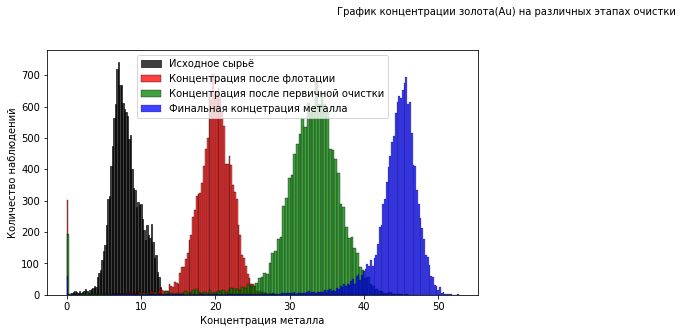

In [23]:
plt.figure(figsize=[17, 15])
plt.subplots_adjust(top=0.94, wspace=0.2, hspace=0.3)
plt.suptitle('График концентрации золота(Au) на различных этапах очистки', fontsize=10)
plt.subplot(3, 2, 1)
sns.histplot(df_train[f'rougher.input.feed_au'], color = 'black', label='Исходное сырьё')
sns.histplot(df_train[f'rougher.output.concentrate_au'], color='r', label='Концентрация после флотации')
sns.histplot(df_train[f'primary_cleaner.output.concentrate_au'], color='g', label='Концентрация после первичной очистки')
sns.histplot(df_train[f'final.output.concentrate_au'], color='b', label='Финальная концетрация металла')
plt.xlabel('Концентрация металла')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

Концентрация золота после различных стадий изменяется в большую сторону. Так, после флотации диапазон значений 15-25, после первичной очистки - 25-40, финальная концентрация от 40 до 50.  
Присутсвуют выбросы

In [24]:
#Ag(серебро)
print(df_full['rougher.output.concentrate_ag'].describe())
print('-------'*5)
print(df_full['primary_cleaner.output.concentrate_ag'].describe())
print('-------'*5)
print(df_full['final.output.concentrate_ag'].describe())

count    19439.000000
mean        11.994759
std          2.733862
min          0.000000
25%         10.628337
50%         12.098115
75%         13.736996
max         24.480271
Name: rougher.output.concentrate_ag, dtype: float64
-----------------------------------
count    19439.000000
mean         8.442408
std          2.054465
min          0.000000
25%          7.263288
50%          8.507298
75%          9.809001
max         16.081632
Name: primary_cleaner.output.concentrate_ag, dtype: float64
-----------------------------------
count    19439.000000
mean         5.168387
std          1.372362
min          0.000000
25%          4.251000
50%          5.066039
75%          5.895401
max         16.001945
Name: final.output.concentrate_ag, dtype: float64


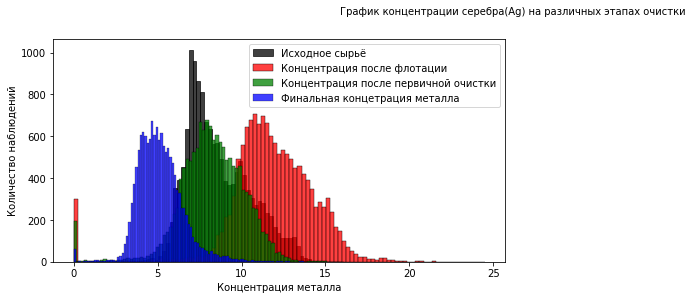

In [25]:
plt.figure(figsize=[17, 15])
plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0.5)
plt.suptitle('График концентрации серебра(Ag) на различных этапах очистки', fontsize=10)
plt.subplot(3, 2, 1)
sns.histplot(df_train[f'rougher.input.feed_ag'], color = 'black', label='Исходное сырьё')
sns.histplot(df_train[f'rougher.output.concentrate_ag'], color='r', label='Концентрация после флотации')
sns.histplot(df_train[f'primary_cleaner.output.concentrate_ag'], color='g', label='Концентрация после первичной очистки')
sns.histplot(df_train[f'final.output.concentrate_ag'], color='b', label='Финальная концетрация металла')
plt.xlabel('Концентрация металла')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

Концентрация серебра на различных стадиях очистки наоборот "деградирует" от 10-17 после флотациии до 7-3 в финальной концентрации.

In [26]:
#Pb(Свинец)
print(df_full['rougher.output.concentrate_pb'].describe())
print('-------'*5)
print(df_full['primary_cleaner.output.concentrate_pb'].describe())
print('-------'*5)
print(df_full['final.output.concentrate_pb'].describe())

count    19439.000000
mean         7.606272
std          1.796757
min          0.000000
25%          6.725987
50%          7.742580
75%          8.565199
max         13.617072
Name: rougher.output.concentrate_pb, dtype: float64
-----------------------------------
count    19439.000000
mean         9.810317
std          2.572253
min          0.000000
25%          8.676500
50%         10.142270
75%         11.416298
max         17.081278
Name: primary_cleaner.output.concentrate_pb, dtype: float64
-----------------------------------
count    19439.000000
mean         9.978821
std          1.669228
min          0.000000
25%          9.137225
50%         10.102264
75%         11.035644
max         17.031899
Name: final.output.concentrate_pb, dtype: float64


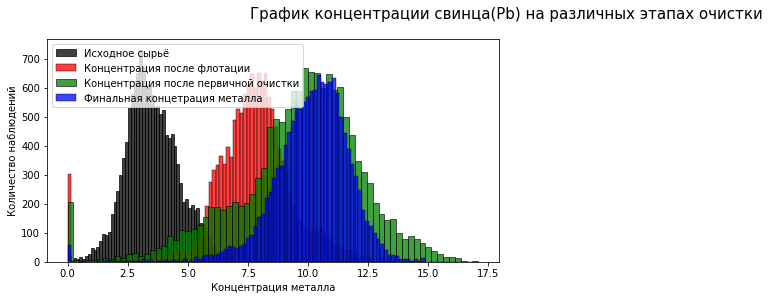

In [27]:
plt.figure(figsize=[17, 15])
plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0.5)
plt.suptitle('График концентрации свинца(Pb) на различных этапах очистки', fontsize=15)
plt.subplot(3, 2, 1)
sns.histplot(df_train[f'rougher.input.feed_pb'], color = 'black', label='Исходное сырьё')
sns.histplot(df_train[f'rougher.output.concentrate_pb'], color='r', label='Концентрация после флотации')
sns.histplot(df_train[f'primary_cleaner.output.concentrate_pb'], color='g', label='Концентрация после первичной очистки')
sns.histplot(df_train[f'final.output.concentrate_pb'], color='b', label='Финальная концетрация металла')
plt.xlabel('Концентрация металла')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

Доля свинца сначала увеличивается на этапе флотации и после первичной очитски(значения 5-12), затем остатется примерно на одном уровне.

**Вывод**  
 
Доля золота(АU) после каждого этапа очитски постепенно увеличивается.  
 
Доля серебра(AG) увеличивается на этапе флотации, а затем на последующих этапах постепенно уменьшается.  

Доля свинца(PB) сначала увеличивается на этапе флотации и после первичной очитски, затем остатется примерно на одном уровне.  
В данных для каждого металла присутствуют околонулевые аномалии, выбросы.

**Сравним распределения размеров гранул сырья на обучающей и тестовой выборках**

In [28]:
#рассмотрим размеры гранул на этапе флотации
print(df_train['rougher.input.feed_size'].describe())
print('-----'*5)
print(df_test['rougher.input.feed_size'].describe())

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64
-------------------------
count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64


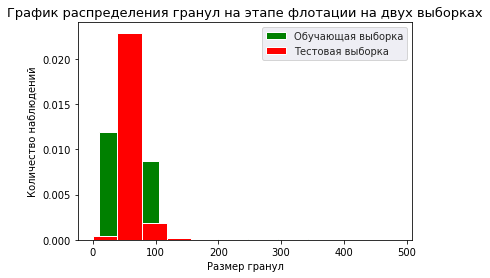

In [29]:
plt.subplot(1, 1, 1)
plt.title(f'График распределения гранул на этапе флотации на двух выборках', fontsize=13)
sns.set_style('darkgrid')
plt.hist(df_train[f'rougher.input.feed_size'], color='g', label='Обучающая выборка', density=True)
plt.hist(df_test[f'rougher.input.feed_size'], color='r', label='Тестовая выборка', density=True)
plt.xlabel('Размер гранул')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

На этапе флотации распределение гранул находится примерно в одинаковом диапазоне: для тестовой выборки преобладают гранулы с размером ~ 50 , а для обучающей гранулы меньшего размера (<50).

In [30]:
#рассмотрим размеры гранул на этапе первичной очистки
print(df_train['primary_cleaner.input.feed_size'].describe())
print('-----'*5)
print(df_test['primary_cleaner.input.feed_size'].describe())

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64
-------------------------
count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


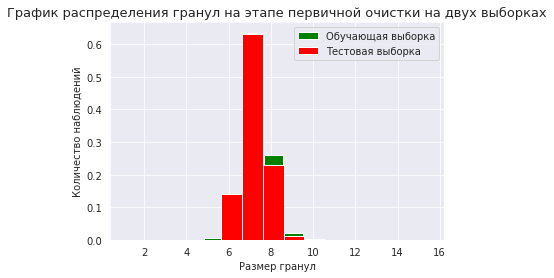

In [31]:
plt.subplot(1, 1, 1)
plt.title(f'График распределения гранул на этапе первичной очистки на двух выборках', fontsize=13)
sns.set_style('darkgrid')
plt.hist(df_train[f'primary_cleaner.input.feed_size'], color='g', label='Обучающая выборка', density=True)
plt.hist(df_test[f'primary_cleaner.input.feed_size'], color='r', label='Тестовая выборка', density=True)
plt.xlabel('Размер гранул')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

На этапе первичной очитски распределение гранул для выборок находится в одном диапазоне(6-10). Наблюдений для тестовой выборки больше чем для обучающей

Таким образом, значимых различий между распределениями для выборок не наблюдается, оценка модели будет правильной.

**Исследум суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах**

In [32]:
#создадим цикл, который подсчитает суммарную концентрацию веществ на разных стадиях:
#в сырье
input_concentrate_total = 0
#в черновом
rougher_output_concentrate_total = 0
#финальный концентрат
final_output_concentrate_total = 0
for metal in ['au', 'ag', 'pb', 'sol']:
    input_concentrate_total += df_train[f'rougher.input.feed_{metal}']
    rougher_output_concentrate_total += df_train[f'rougher.output.concentrate_{metal}']
    final_output_concentrate_total += df_train[f'final.output.concentrate_{metal}']

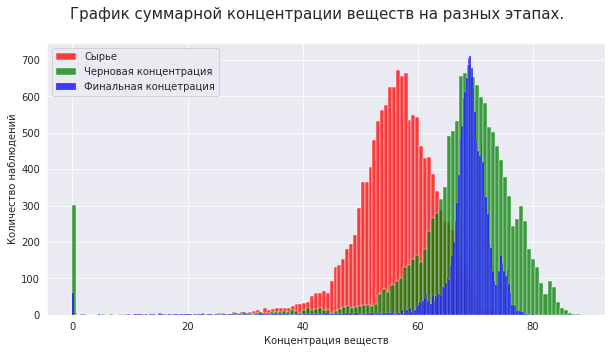

In [33]:
plt.figure(figsize=[10, 5])
plt.suptitle('График суммарной концентрации веществ на разных этапах.', fontsize=15)
sns.histplot(input_concentrate_total, color='r', label='Сырье', kde=False)
sns.histplot(rougher_output_concentrate_total, color='g', label='Черновая концентрация', kde=False)
sns.histplot(final_output_concentrate_total, color='b', label='Финальная концетрация',kde=False)
plt.xlabel('Концентрация веществ')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

Суммарная концентрация веществ постепенно увеличивается с прохождением очисток. На финальной концентрации видно уменьшение диапазона разброса данных.  

Удалим присутсвующие в данных околонулевые выбросы, которые могут повлиять на точность построения модели.

In [34]:
df_train = df_train[(df_train['rougher.output.concentrate_au'] != 0) & (df_train['rougher.output.concentrate_ag'] != 0) & (df_train['rougher.output.concentrate_pb'] != 0) & (df_train['rougher.output.concentrate_sol'] != 0)]
df_train = df_train[(df_train['final.output.concentrate_au'] != 0) & (df_train['final.output.concentrate_ag'] != 0) & (df_train['final.output.concentrate_pb'] != 0) & (df_train['final.output.concentrate_sol'] != 0)]

In [35]:
#создадим цикл, который подсчитает суммарную концентрацию веществ на разных стадиях:
#в сырье
input_concentrate_total = 0
#в черновом
rougher_output_concentrate_total = 0
#финальный концентрат
final_output_concentrate_total = 0
for metal in ['au', 'ag', 'pb', 'sol']:
    input_concentrate_total += df_train[f'rougher.input.feed_{metal}']
    rougher_output_concentrate_total += df_train[f'rougher.output.concentrate_{metal}']
    final_output_concentrate_total += df_train[f'final.output.concentrate_{metal}']

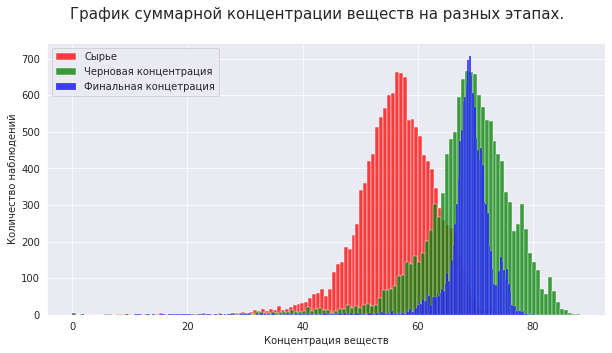

In [36]:
plt.figure(figsize=[10, 5])
plt.suptitle('График суммарной концентрации веществ на разных этапах.', fontsize=15)
sns.histplot(input_concentrate_total, color='r', label='Сырье', kde=False)
sns.histplot(rougher_output_concentrate_total, color='g', label='Черновая концентрация', kde=False)
sns.histplot(final_output_concentrate_total, color='b', label='Финальная концетрация',kde=False)
plt.xlabel('Концентрация веществ')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

**Вывод**  

В ходе исследования и анализа данных выяснили: 
 - Распределения гранул сырья на обучающей и тестовой выборках нормальное, значительных различий не выявлено, влияния на построение модели не случится

 - Доля золота увеличивается по мере прохождения этапов очистки

 - cуммарная концентрация веществ увеличивается после прохода стадий очистки.
 
 - в данных присутствовали аномалии(околонулевые значения)

## Модель

Начнём с того, что удалим не нужные нам признаки, оставив только требуемые для построения модели.

In [37]:
signs_for_delete_without_target_signs = missed_columns - set(['rougher.output.recovery','final.output.recovery'])

In [38]:
df_train = df_train.drop(columns=signs_for_delete_without_target_signs, axis=1)

Напишем функцию, высчитывающию метрику sMAPE

In [39]:
def sMAPE(target, predict):
    smape = (1/len(target))*np.sum((np.abs(target - predict))/( (np.abs(target)+np.abs(predict))/2))*100
    return smape

In [40]:
smape_scorer = make_scorer(sMAPE, greater_is_better = False)

Напишем функцию,высчитывающую финальный sMAPE

In [41]:
def final_sMAPE(rougher, final):
    final = 0.25*rougher+0.75*final
    return final

Подготовим исходные данные:

In [42]:
features_train = df_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_train = df_train['rougher.output.recovery']
target_final_train = df_train['final.output.recovery']

**Линейная регрессия** 

In [43]:
%%time
from sklearn.pipeline import make_pipeline

scaler = StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)


model_lr = LinearRegression()
smape_rougher = cross_val_score(model_lr,
                          features_train,
                          target_train,
                          scoring=smape_scorer,
                          cv=5)
final_smape_rougher = smape_rougher.mean()
model_lr_final = LinearRegression()
# оценим модель с помощью кроссвалидации features_train, target_train
smape_final = cross_val_score(model_lr_final,
                        features_train,
                        target_final_train,
                        scoring=smape_scorer,
                        cv=5)
final_smape_final = smape_final.mean()
result_smape = final_sMAPE(final_smape_rougher, final_smape_final)*(-1)
print('Средняя оценка качества модели линейной регрессии', round(result_smape, 4))

Средняя оценка качества модели линейной регрессии 10.0593
CPU times: user 3.23 s, sys: 4.57 s, total: 7.81 s
Wall time: 7.95 s


**Дерево решений**

In [44]:
%%time
best_result_for_dt = 100
best_param_for_dt = 0
for n in range(1, 10, 1):
    model_dt_rougher = DecisionTreeRegressor(max_depth=8, random_state=12345)
    smape_rougher = cross_val_score(model_dt_rougher,
                              features_train,
                              target_train,
                              scoring=smape_scorer,
                              cv=5)
    final_smape_rougher = smape_rougher.mean()

    model_dt_final = DecisionTreeRegressor(max_depth=n, random_state=12345)
    smape_final = cross_val_score(model_dt_final, 
                                  features_train,
                                  target_final_train,
                                  scoring=smape_scorer,
                                  cv=5)
    final_smape_final = smape_final.mean()
    result_smape = final_sMAPE(final_smape_rougher, final_smape_final)*(-1)
    if result_smape < best_result_for_dt:
        best_result_for_dt = result_smape
print('Средняя оценка качества модели решающего дерева', round(result_smape, 4))

Средняя оценка качества модели решающего дерева 11.6735
CPU times: user 32.2 s, sys: 297 ms, total: 32.5 s
Wall time: 33.5 s


**Случайный лес**

In [45]:
%%time
# Проведем оценку модели случайного леса с заданными параметрами для этапа rougher
model_RF_rougher = RandomForestRegressor(random_state=12345, max_depth = 4, n_estimators=10)


scores_RF_rougher = cross_val_score(model_RF_rougher,
                                    features_train, 
                                    target_train,
                                    scoring=smape_scorer,
                                    cv = 5)
smape_RF_rougher = np.mean(abs(scores_RF_rougher))
print('Средняя оценка качества модели final_score_rf_rougher', round(smape_RF_rougher, 4))

Средняя оценка качества модели final_score_rf_rougher 6.6861
CPU times: user 6.82 s, sys: 58.6 ms, total: 6.88 s
Wall time: 6.91 s


In [46]:
%%time
# Проведем оценку модели случайного леса с заданными параметрами для этапа final
#  инициируем модель случайного леса
model_RF_final = RandomForestRegressor(random_state=12345, max_depth = 4, n_estimators=10)

# оценим модель с помощью кроссвалидации features_train, target_train
scores_RF_final = cross_val_score(model_RF_final,
                                    features_train, 
                                    target_final_train,
                                    scoring=smape_scorer,
                                    cv = 5)
smape_RF_final = np.mean(abs(scores_RF_final))
print('Средняя оценка качества модели final_score_rf_rougher', round(smape_RF_final, 4))

Средняя оценка качества модели final_score_rf_rougher 9.1437
CPU times: user 7.12 s, sys: 23.7 ms, total: 7.14 s
Wall time: 7.28 s


In [47]:
# вычислим итоговую оценку smape_rf_total 
smape_RF_total = final_sMAPE(smape_RF_rougher, smape_RF_final)
print('Средняя итоговая оценка качества модели smape_rf_total', round(smape_RF_total, 4))

Средняя итоговая оценка качества модели smape_rf_total 8.5293


Проведем оценку модели случайного леса с подбором параметров для этапа rougher, чтобы подобрать правильный диапазон, воспользовался документацией.

In [48]:
#%%time

#model_RF_rougher = RandomForestRegressor(random_state=12345)

# подберем оптимальные параметры глубины дерева
#parameters = { 'max_depth': [x for x in range(2, 12, 3)],'n_estimators': [x for x in range(100, 150, 80)]}

#grid_RF_rougher = GridSearchCV(model_rf_rougher, parameters, cv=5, scoring=smape_scorer)
#grid_RF_rougher.fit(features_train, target_train)

Поскольку длительность вычисления составила 7.5 минут, закомментирую код и напишу итоговый результат

Лучшие параметры: max depth = 5, n_estimators = 100  
smape_rougher = 11.062

Проведем оценку модели случайного леса с подбором параметров для этапа final.

In [49]:
#%%time
#model_RF_final = RandomForestRegressor(random_state=12345)

#parameters = { 'max_depth': [x for x in range(2, 10, 2)], 'n_estimators': [x for x in range(100, 150, 80)]}

#grid_RF_final = GridSearchCV(model_rf_final, parameters, cv=5, scoring=smape_scorer)
#grid_RF_final.fit(features_train, target_final_train)

Подсчёт данной метрики занял 5 минут 31 секунду, выданные результаты таковы:

Лучшие параметры: max_depth: 4, n_estimators: 100  
smape_rougher = 10.275

Вычислим итоговую оценку sMAPE с учётом подбора параметров 

In [50]:
smape_RF_total = final_sMAPE(11.062, 10.275)
print('Средняя итоговая оценка качества модели smape_rf_total', round(smape_RF_total, 4))

Средняя итоговая оценка качества модели smape_rf_total 10.4718


**Лучшая модель - RandomForestRegressor**

Подготовим данные для тестирования

In [51]:
features_test = df_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_rougher_test = df_test['rougher.output.recovery']
target_final_test = df_test['final.output.recovery']

Применим модель randomForestRegressor на тестовой выборке c подобранными ранее параметрами.

In [52]:
model_test_rougher = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=12345)
model_test_rougher.fit(features_train, target_train)
predicted_rougher = model_test_rougher.predict(features_test)

model_test_final = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=12345)
model_test_final.fit(features_train, target_final_train)
predicted_final = model_test_final.predict(features_test)

smape_test_rougher = sMAPE(target_rougher_test, predicted_rougher)
smape_test_final = sMAPE(target_final_test, predicted_final)
final_smape_for_test = final_sMAPE(smape_test_rougher, smape_test_final)

print('Итоговая оценка smape на тестовых данных равна', round(final_smape_for_test, 2))

Итоговая оценка smape на тестовых данных равна 9.24


Проверим модель на адекватность, заимствую опыт из предыдущих проектов, где мы проверяли модель на адекватность. Используем библиотеку dummyregressor.

In [53]:
dummy_rougher = DummyRegressor(strategy="mean")
dummy_final = DummyRegressor(strategy="mean")

dummy_rougher.fit(features_train, target_train)
dummy_final.fit(features_train, target_final_train)

dummy_pred_rougher = dummy_rougher.predict(features_test)
dummy_pred_final = dummy_final.predict(features_test)

smape_const_rougher = sMAPE(target_rougher_test, dummy_pred_rougher)
smape_const_final = sMAPE(target_final_test, dummy_pred_final)

final_smape_const = final_sMAPE(smape_const_rougher, smape_const_final)

print('Итоговая оценка smape константной модели на тестовых данных равна - ', final_smape_const)

Итоговая оценка smape константной модели на тестовых данных равна -  9.82146839182027


**Вывод по построению моделей**  

 - посчитаны метрики sMAPE для двух целевых признаков rougher(флотация) и final(окончательная концентрация)
 - найдены оптимальные параметры для модели случайного леса, лучшая модель также оказалась с использованием случ.леса.
 - посчитаны данные на тестовой выборке и проврены с помощью dummy. Данные удовлетворяют решению.
 

  **ОБЩИЙ ВЫВОД**  

После проделанного исследования проведем полный обзор:

 - Данные были открыты и проанализированы, обнаружены таблицы с 87 признаками, в данных были пропуски, которые заменены близлежайшими по дате значениями. Дубликатов не обнаружено.

 - Проверен расчёт эффективности обогащения путём вычисления метрики МАЕ. Полученные значения близки к 0. Это значит, что эффективность обогащения рассчитана верно.

 - Проанализированы поля, отсутсвующие в тестовой выборке - это целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. Это концентрации элементов после основных операций.

 - Анализ концентрации металлов показал, что концентрация золота значительно увеличивается на каждом этапе обработки сырья. Концентрация золота в отвалах тоже увеличивается, но при этом сильно ниже чем в сырье.

 - Построены графики распределения плотности вероятности значений размеров гранул на этапах флотации и финальной очистки.

 - Исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

 - Подготовлены датафреймы для прогнозирования features, target

 - Написана функция, вычисляющая итоговый и финальный sMAPE.

 - На данных train обучены модели линейной регрессии, дерева решений, а также случайного леса. Проведена оценка каждой модели. В результате для дальнешего прогнозирования выбирана модель случайного леса с параметрами

  - для этапа rougher глубина 5, количество деревьев 100.
  - для этапа final глубина 4, количество деревьев 100.  
  
при данных параметрах в датафрейме train показатель smape равен 10.4718

Итоговый расчёт на тестовых данных выбранной модели случайного леса позволил получить прогноз целевых признаков концентрации золота для этапа флотации и финальной очистки с показателем smape равным 9.82

Проведена проверка модели на адекватность. Модель адекватна.